# Implementation of the higher order and interaction features

In [1]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [2]:
project_dir = os.getcwd().split('\\')[:-1]
project_dir = '\\'.join(project_dir)
data_dir = project_dir + '\\data'
processed_dir = data_dir + '\\processed'
processed_files = os.listdir(processed_dir)
processed_files = [file for file in processed_files if file.endswith('hdf')]

In [3]:
WINDOW = 180
STEP = 1
df = pd.read_hdf(f'{processed_dir}\\window_{WINDOW}_step_{int(WINDOW * STEP)}.hdf')
features = ['mean_AU01', 'mean_change_AU01', 'mean_AU02', 'mean_change_AU02', 'mean_AU04',
           'mean_change_AU04', 'mean_AU05', 'mean_change_AU05', 'mean_AU06',
           'mean_change_AU06', 'mean_AU07', 'mean_change_AU07', 'mean_AU09',
           'mean_change_AU09', 'mean_AU10', 'mean_change_AU10', 'mean_AU12',
           'mean_change_AU12', 'mean_AU14', 'mean_change_AU14', 'mean_AU15',
           'mean_change_AU15', 'mean_AU17', 'mean_change_AU17', 'mean_AU20',
           'mean_change_AU20', 'mean_AU23', 'mean_change_AU23', 'mean_AU25',
           'mean_change_AU25', 'mean_AU26', 'mean_change_AU26', 'mean_AU45',
           'mean_change_AU45', 'std_AU01', 'std_AU02', 'std_AU04', 'std_AU05',
           'std_AU06', 'std_AU07', 'std_AU09', 'std_AU10', 'std_AU12', 'std_AU14',
           'std_AU15', 'std_AU17', 'std_AU20', 'std_AU23', 'std_AU25', 'std_AU26',
           'std_AU45', 'mean_Arousal', 'mean_Happy', 'mean_Sad', 'mean_Angry',
           'mean_Scared', 'std_pose_Tx', 'std_pose_Ty', 'std_pose_Tz',
           'std_pose_Rx', 'std_pose_Ry', 'std_pose_Rz', 'compound_Motion',
           'mean_PD', 'std_PD', 'max_PD', 'blink_rate', 'per_EC']
targets = ['mean_SCL', 'mean_offset', 'range_corrected_mean_SCL', 'standardised_mean_scl',
           'frequency_NS_SCR', 'HRV_MeanNN', 'HRV_RMSSD', 'HRV_SDNN', 'HRV_MeanNN_corrected',
           'HRV_RMSSD_corrected', 'HRV_SDNN_corrected']
cols = features + targets + ['pp']
data = df[targets+['pp']] 

In [4]:
pf = PolynomialFeatures(2, interaction_only=True, include_bias=False)
data[pf.get_feature_names(df[features].columns)] = pd.DataFrame(pf.fit_transform(df[features]))
features = pf.get_feature_names(df[features].columns)

D:\Anaconda\envs\Video_Stress\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [5]:
testset_pp = random.sample(list(data.pp.unique()), 10)
test_df = data[data.pp.isin(testset_pp)]
train_df = data[~data.pp.isin(testset_pp)]

In [6]:
predicted_data = pd.DataFrame()
for target in targets:
    scaler = StandardScaler()
    train_X = scaler.fit_transform(X=train_df[features], y=train_df[target])

    LPSO = GroupKFold(n_splits=10)
    split_iter = LPSO.split(train_X, train_df[target], train_df.pp)

    MSE = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

    tuned_parameters = [{'alpha': [0.1, 1, 10, 100, 1000, 10000], 'l1_ratio':[0.1, 0.5, 0.9, 0.99]}]

    regression = GridSearchCV(ElasticNet(max_iter = 100000, normalize=False, random_state=0, tol=0.01),
                            tuned_parameters, cv=split_iter)
    
    print(f'Finding best parameters using CV for: {target}')
    
    regression.fit(train_X, train_df[target])
    print("Best parameters set found on validation set:")
    print(regression.best_params_)
    print("Best score found on validation set:")
    print(regression.best_score_)
    print(f'R Squared found on test data: \n\n{regression.best_estimator_.score(X=scaler.transform(test_df[features]), y=test_df[target])}')
    
    print('Saving predictions from best model on test dataset.')
    pred_y = regression.best_estimator_.predict(X=scaler.transform(test_df[features]))
    true_y = test_df[target]
    pps = test_df.pp
    new_data = pd.DataFrame({'true_y': true_y, 'predicted_y': pred_y, 'pp':pps})
    new_data['target'] = target
    predicted_data = pd.concat([predicted_data, new_data], join='outer', ignore_index=True)

predicted_data.to_hdf(f'{processed_dir}\\predicted_data_LR.hdf', "data", mode="w")

Finding best parameters using CV for: mean_SCL
Best parameters set found on validation set:
{'alpha': 10, 'l1_ratio': 0.5}
Best score found on validation set:
-0.6132523931208477
R Squared found on test data: 

-0.41936985557308004
Saving predictions from best model on test dataset.
Finding best parameters using CV for: mean_offset
Best parameters set found on validation set:
{'alpha': 1, 'l1_ratio': 0.9}
Best score found on validation set:
-0.24349117487149075
R Squared found on test data: 

-0.34008460078979086
Saving predictions from best model on test dataset.
Finding best parameters using CV for: range_corrected_mean_SCL
Best parameters set found on validation set:
{'alpha': 1, 'l1_ratio': 0.1}
Best score found on validation set:
-0.1093251050317812
R Squared found on test data: 

-0.4335988137322786
Saving predictions from best model on test dataset.
Finding best parameters using CV for: standardised_mean_scl
Best parameters set found on validation set:
{'alpha': 0.1, 'l1_ratio':

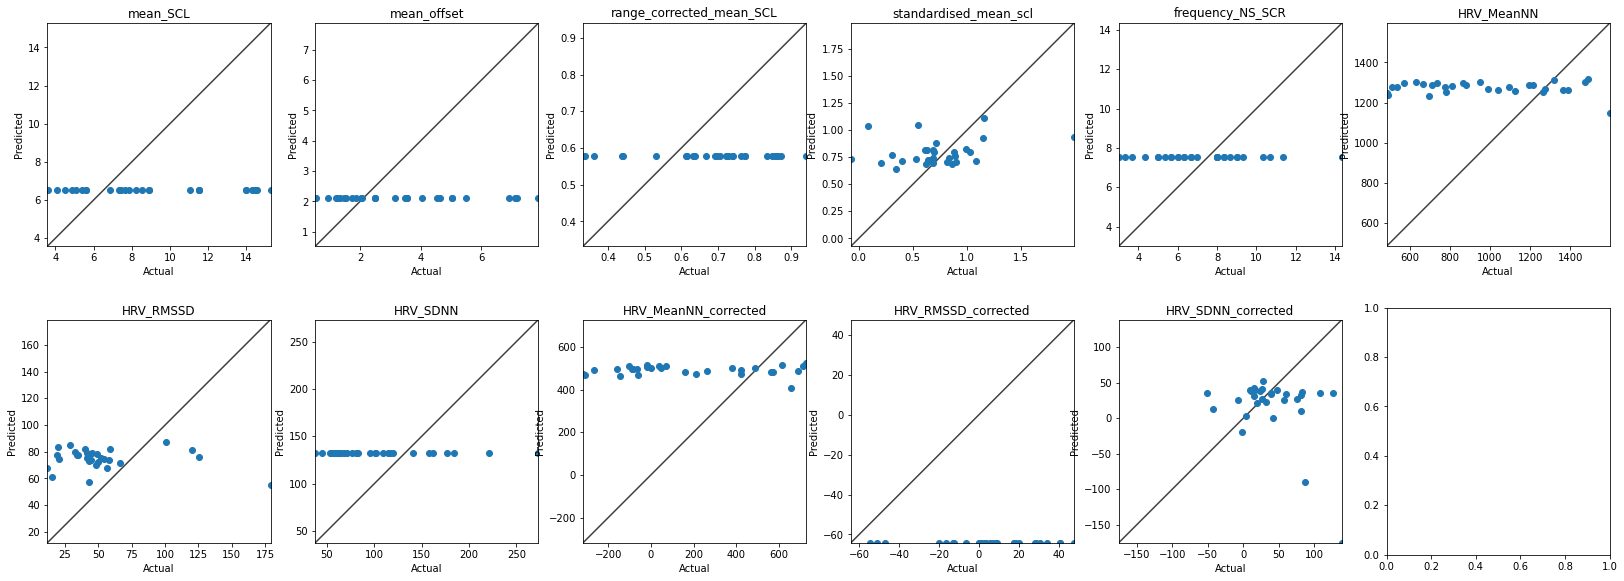

In [7]:
f, axes = plt.subplots(2, 6, figsize=(28,10))
for i in range(len(targets)):
    target = targets[i]
    vmin = predicted_data.loc[predicted_data.target==target, ['true_y', 'predicted_y']].min().min()
    vmax = predicted_data.loc[predicted_data.target==target, ['true_y', 'predicted_y']].max().max()
    ax = axes[int(i/6), i%6]
    ax.scatter(x = predicted_data.loc[predicted_data.target==target, 'true_y'], y = predicted_data.loc[predicted_data.target==target, 'predicted_y'])
    ax.set_title(target)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.plot((vmin, vmax),(vmin, vmax), 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')

In [8]:
data.columns

Index(['mean_SCL', 'mean_offset', 'range_corrected_mean_SCL',
       'standardised_mean_scl', 'frequency_NS_SCR', 'HRV_MeanNN', 'HRV_RMSSD',
       'HRV_SDNN', 'HRV_MeanNN_corrected', 'HRV_RMSSD_corrected',
       ...
       'mean_PD std_PD', 'mean_PD max_PD', 'mean_PD blink_rate',
       'mean_PD per_EC', 'std_PD max_PD', 'std_PD blink_rate', 'std_PD per_EC',
       'max_PD blink_rate', 'max_PD per_EC', 'blink_rate per_EC'],
      dtype='object', length=2358)